In [16]:
import os
import h5py
import librosa.display
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

In [2]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def load_binary_spectrograms(hdf5_file):
    # Load spectrograms from HDF5, normalize and reshape them, then split into train/val/test sets.
    labels = ['amerob', 'rewbla']
    data = []
    labels_list = []

    with h5py.File(hdf5_file, 'r') as data_file:
        for label in labels:
            spectrogram = data_file[label][...].astype(np.float32)
            spectrogram = normalize_db_scale(spectrogram)           
            spectrogram = np.transpose(spectrogram, (2, 0, 1))
            data.append(spectrogram)
            label_id = labels.index(label)
            labels_list.append(np.full(spectrogram.shape[0], label_id, dtype=np.uint8))

    X = np.concatenate(data, axis=0)[..., np.newaxis]
    y = np.concatenate(labels_list, axis=0)
    X, y = shuffle(X, y, random_state=123)

    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=123
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=123
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

def normalize_db_scale(spectrogram, min_db=-80.0, max_db=0.0):
    # Clip dB values to [min_db, max_db] and scale linearly to [0, 1].
    spectrogram = np.clip(spectrogram, min_db, max_db)
    return (spectrogram - min_db) / (max_db - min_db)

def build_binary_cnn(input_shape, learning_rate=1e-4, dropout_rate=0.5, l2_reg=0.02):
    # Construct a 2-layer CNN with dropout and L2 regularization, compile with Adam and binary cross-entropy.
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(16, (5, 5), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

def train_model_with_callbacks(model, X_train, y_train, X_val, y_val, epochs=200, batch_size=32):
    # Train `model` using early stopping, best-model checkpointing, and LR reduction on plateau.
    checkpoint_path = r"D:\University_Course_work\StatsML-2\Deeplearning\Practical_Home_Work\species_learning_with_deep_learning\training_and_evaluation\binarymodels\cnn_amerob_rewbla_model.keras"

    es = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    callbacks = [
        es,
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, verbose=0),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=0
    )

    if hasattr(es, 'stopped_epoch') and es.stopped_epoch > 0:
        print(f"Early stopping triggered at epoch {es.stopped_epoch}")
    else:
        print(f"Training completed all {len(history.history['loss'])} epochs")

    return history

def plot_training_performance(history):
    # Plot training vs. validation accuracy and loss over epochs.
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

    plt.tight_layout()
    plt.show()

def train_and_evaluate_model(hdf5_path, model_name='cnn_binary', batch_size=32, epochs=200,
                             learning_rate=1e-4, dropout_rate=0.5, l2_reg=0.02):
    # Full pipeline: load data, build CNN, train with callbacks, plot metrics, evaluate on test set, save model.
    X_train, X_val, X_test, y_train, y_val, y_test = load_binary_spectrograms(hdf5_path)

    model = build_binary_cnn(
        input_shape=(128, 517, 1),
        learning_rate=learning_rate,
        dropout_rate=dropout_rate,
        l2_reg=l2_reg
    )

    history = train_model_with_callbacks(
        model, X_train, y_train, X_val, y_val,
        epochs=epochs, batch_size=batch_size
    )

    plot_training_performance(history)

    y_pred_prob = model.predict(X_test, verbose=0).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    metrics = {
        "model_name": model_name,
        "accuracy":  accuracy_score(y_test, y_pred),
        "auc":       roc_auc_score(y_test, y_pred_prob),
        "precision": precision_score(y_test, y_pred),
        "recall":    recall_score(y_test, y_pred),
        "f1":        f1_score(y_test, y_pred),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

    print(f"\n--- Evaluation Metrics for {model_name} ---")
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"AUC:       {metrics['auc']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1 Score:  {metrics['f1']:.4f}")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")

    save_path = rf"D:\University_Course_work\StatsML-2\Deeplearning\Practical_Home_Work\species_learning_with_deep_learning\training_and_evaluation\binarymodels\{model_name}.keras"
    model.save(save_path)

    return metrics


Training completed all 50 epochs


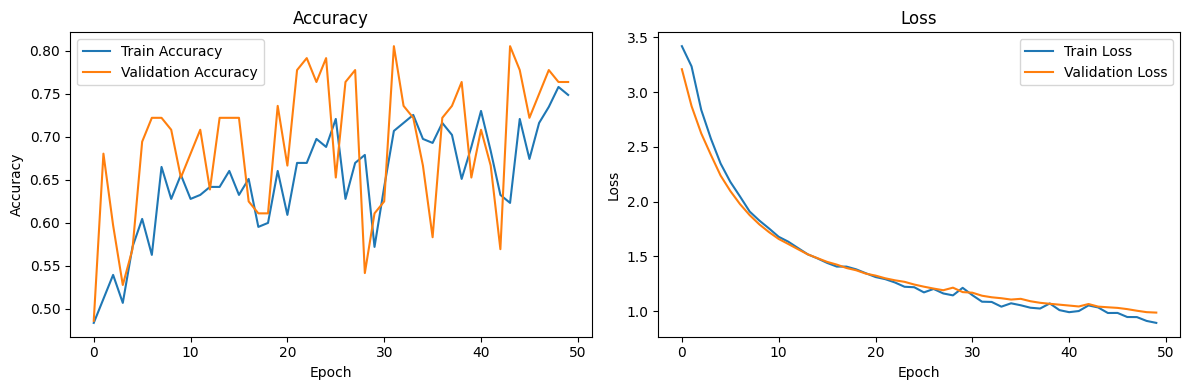


--- Evaluation Metrics for model_1_binary_cnn ---
Accuracy:  0.7222
AUC:       0.7663
Precision: 0.7647
Recall:    0.6842
F1 Score:  0.7222
Confusion Matrix:
[[26  8]
 [12 26]]


In [3]:
model_1 = train_and_evaluate_model(
    hdf5_path="D:/University_Course_Work/StatsML-2/Deeplearning/Practical_Home_Work/species_learning_with_deep_learning/Data/bird_spectrograms.hdf5",
    model_name='model_1_binary_cnn', 
    batch_size=32,
    epochs=50,
    learning_rate=1e-4,
    dropout_rate=0.3,
    l2_reg=0.01
)

Early stopping triggered at epoch 44


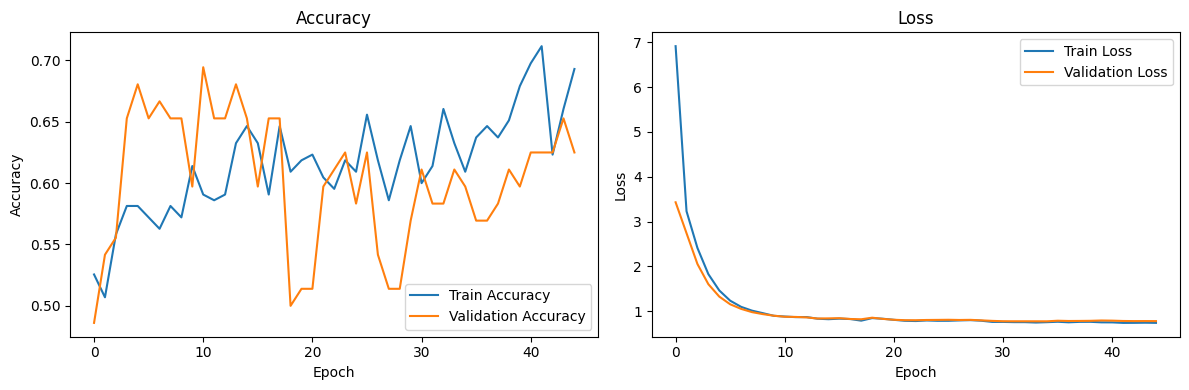


--- Evaluation Metrics for model_2_binary_cnn ---
Accuracy:  0.5833
AUC:       0.6788
Precision: 0.5645
Recall:    0.9211
F1 Score:  0.7000
Confusion Matrix:
[[ 7 27]
 [ 3 35]]


In [4]:
model_2 = train_and_evaluate_model(
    hdf5_path="D:/University_Course_Work/StatsML-2/Deeplearning/Practical_Home_Work/species_learning_with_deep_learning/Data/bird_spectrograms.hdf5",
    model_name='model_2_binary_cnn', 
    batch_size=16,          
    epochs=50,              
    learning_rate=1e-3,    
    dropout_rate=0.5,   
    l2_reg=0.01             
)


Early stopping triggered at epoch 99


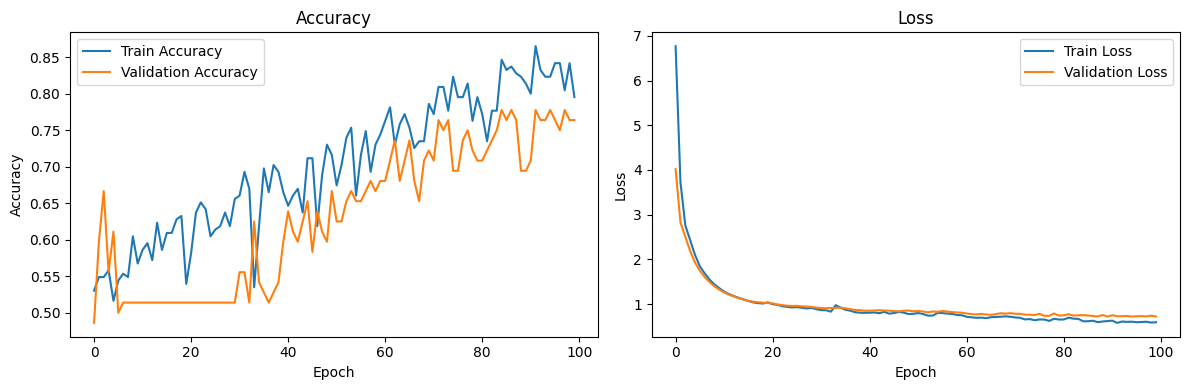


--- Evaluation Metrics for model_3_binary_cnn ---
Accuracy:  0.7222
AUC:       0.7639
Precision: 0.6731
Recall:    0.9211
F1 Score:  0.7778
Confusion Matrix:
[[17 17]
 [ 3 35]]


In [5]:
model_3 = train_and_evaluate_model(
    hdf5_path="D:/University_Course_Work/StatsML-2/Deeplearning/Practical_Home_Work/species_learning_with_deep_learning/Data/bird_spectrograms.hdf5",
    model_name='model_3_binary_cnn', 
    batch_size=32,          
    epochs=100,             
    learning_rate=5e-4,    
    dropout_rate=0.3,       
    l2_reg=0.02
)


Training completed all 100 epochs


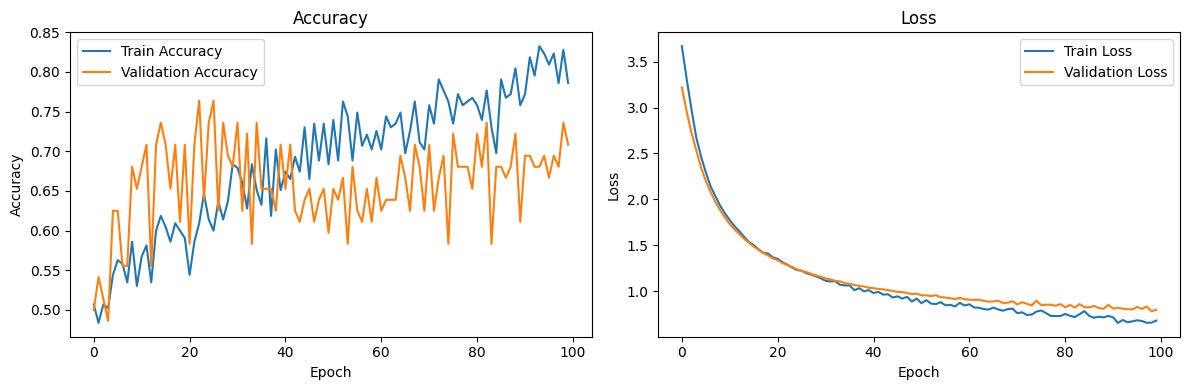


--- Evaluation Metrics for model_4_binary_cnn ---
Accuracy:  0.6667
AUC:       0.7848
Precision: 0.6750
Recall:    0.7105
F1 Score:  0.6923
Confusion Matrix:
[[21 13]
 [11 27]]


In [6]:
model_4 = train_and_evaluate_model(
    hdf5_path="D:/University_Course_Work/StatsML-2/Deeplearning/Practical_Home_Work/species_learning_with_deep_learning/Data/bird_spectrograms.hdf5",
    model_name='model_4_binary_cnn',
    batch_size=32,
    epochs=100,
    learning_rate=1e-4,
    dropout_rate=0.4,
    l2_reg=0.01
)


Training completed all 20 epochs


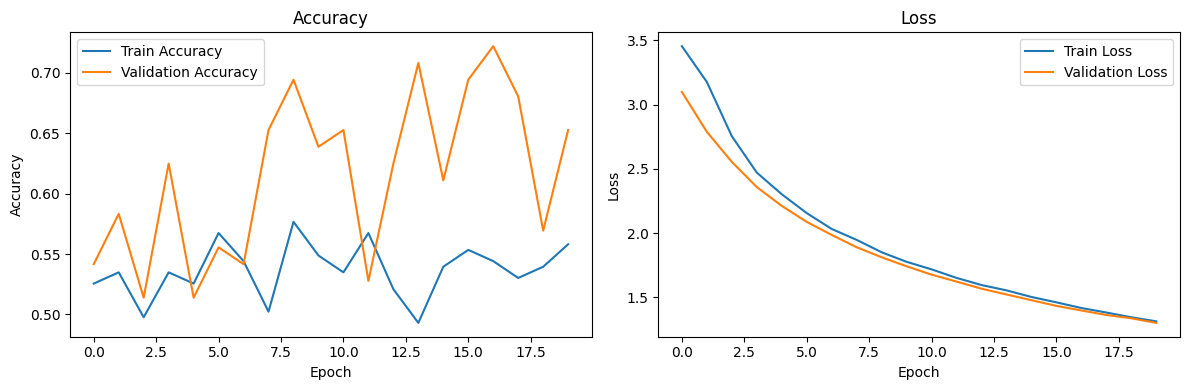


--- Evaluation Metrics for model_5_binary_cnn ---
Accuracy:  0.5694
AUC:       0.6424
Precision: 0.5660
Recall:    0.7895
F1 Score:  0.6593
Confusion Matrix:
[[11 23]
 [ 8 30]]


In [7]:
model_5 = train_and_evaluate_model(
    hdf5_path="D:/University_Course_Work/StatsML-2/Deeplearning/Practical_Home_Work/species_learning_with_deep_learning/Data/bird_spectrograms.hdf5",
    model_name='model_5_binary_cnn',
    batch_size=16,
    epochs=20,
    learning_rate=1e-4,
    dropout_rate=0.5,
    l2_reg=0.01
)

Training completed all 20 epochs


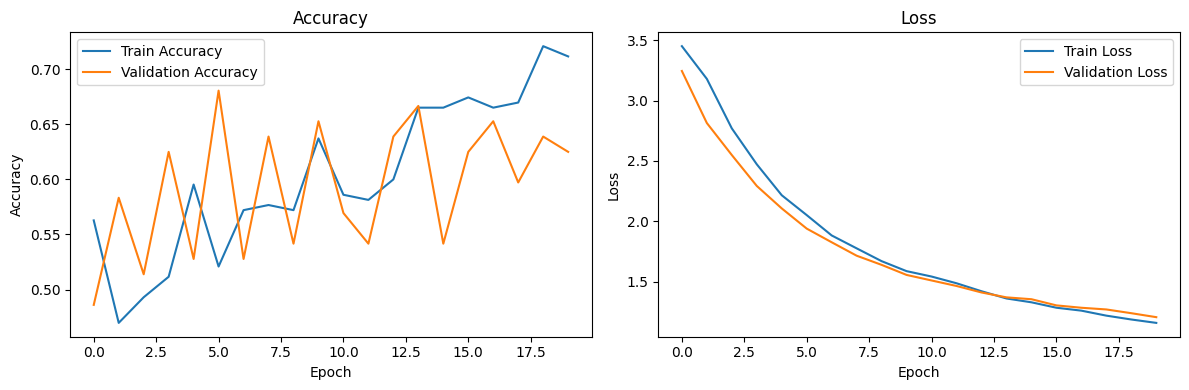


--- Evaluation Metrics for model_6_binary_cnn ---
Accuracy:  0.7500
AUC:       0.7585
Precision: 0.7632
Recall:    0.7632
F1 Score:  0.7632
Confusion Matrix:
[[25  9]
 [ 9 29]]


In [8]:
model_6 = train_and_evaluate_model(
    hdf5_path="D:/University_Course_Work/StatsML-2/Deeplearning/Practical_Home_Work/species_learning_with_deep_learning/Data/bird_spectrograms.hdf5",
    model_name='model_6_binary_cnn',
    batch_size=32,
    epochs=20,
    learning_rate=1e-4,
    dropout_rate=0.2,
    l2_reg=0.01
)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compare_models(*results, normalize_cm=False):
    """
    Compare multiple binary classification models using:
    - Tabular display of metrics
    - Bar chart
    - Heatmap
    - Confusion matrix plots
    
    Parameters:
        results: Arbitrary number of result dicts
        normalize_cm (bool): If True, normalizes confusion matrices row-wise
    """
    metrics_df = pd.DataFrame([
        {k: v for k, v in r.items() if k != 'confusion_matrix'} for r in results
    ])
    metrics_df = metrics_df.set_index("model_name")
    metrics_df = metrics_df.sort_values("f1", ascending=False)

    print("\nModel Evaluation Summary (sorted by F1 Score):")
    print(metrics_df.round(4).to_markdown())


    metrics_df.plot(kind='bar', figsize=(12, 6), colormap='tab10')
    plt.title("Model Metric Comparison (Sorted by F1 Score)")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.heatmap(metrics_df, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
    plt.title("Model Performance Heatmap")
    plt.tight_layout()
    plt.show()

    # Confusion Matrices
    for r in results:
        cm = r["confusion_matrix"]
        if normalize_cm:
            cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        model_name = r["model_name"]

        plt.figure(figsize=(4, 4))
        sns.heatmap(cm, annot=True, fmt=".2f" if normalize_cm else 'd',
                    cmap='Blues', cbar=False,
                    xticklabels=["amerob", "rewbla"],
                    yticklabels=["amerob", "rewbla"])
        plt.title(f"Confusion Matrix: {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()



Model Evaluation Summary (sorted by F1 Score):
| model_name         |   accuracy |    auc |   precision |   recall |     f1 |
|:-------------------|-----------:|-------:|------------:|---------:|-------:|
| model_3_binary_cnn |     0.7222 | 0.7639 |      0.6731 |   0.9211 | 0.7778 |
| model_6_binary_cnn |     0.75   | 0.7585 |      0.7632 |   0.7632 | 0.7632 |
| model_1_binary_cnn |     0.7222 | 0.7663 |      0.7647 |   0.6842 | 0.7222 |
| model_2_binary_cnn |     0.5833 | 0.6788 |      0.5645 |   0.9211 | 0.7    |
| model_4_binary_cnn |     0.6667 | 0.7848 |      0.675  |   0.7105 | 0.6923 |
| model_5_binary_cnn |     0.5694 | 0.6424 |      0.566  |   0.7895 | 0.6593 |


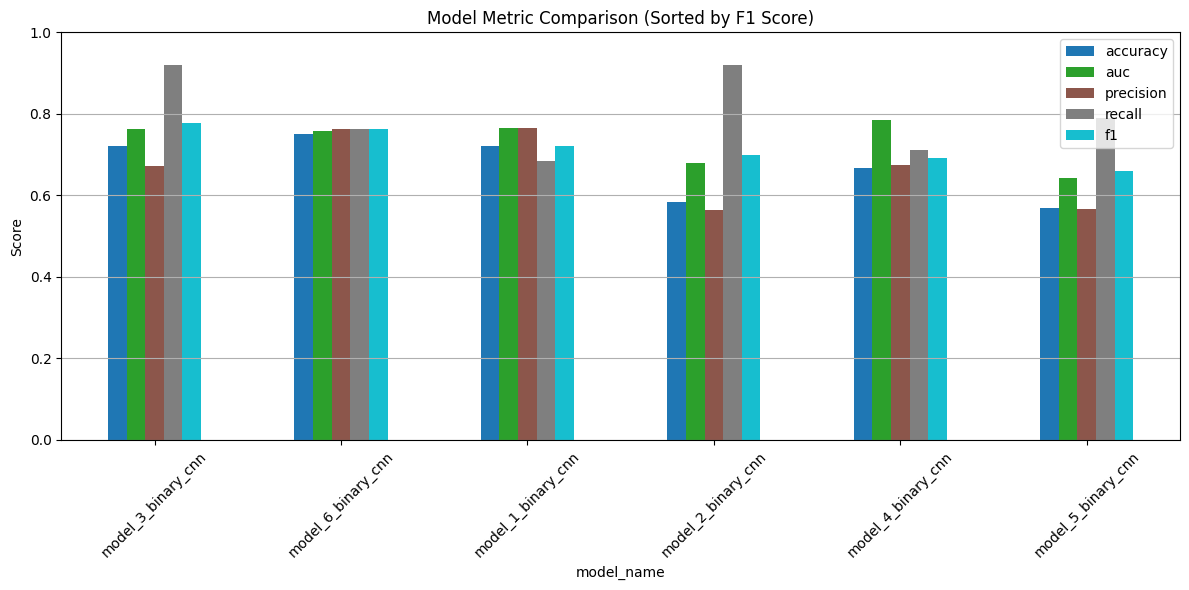

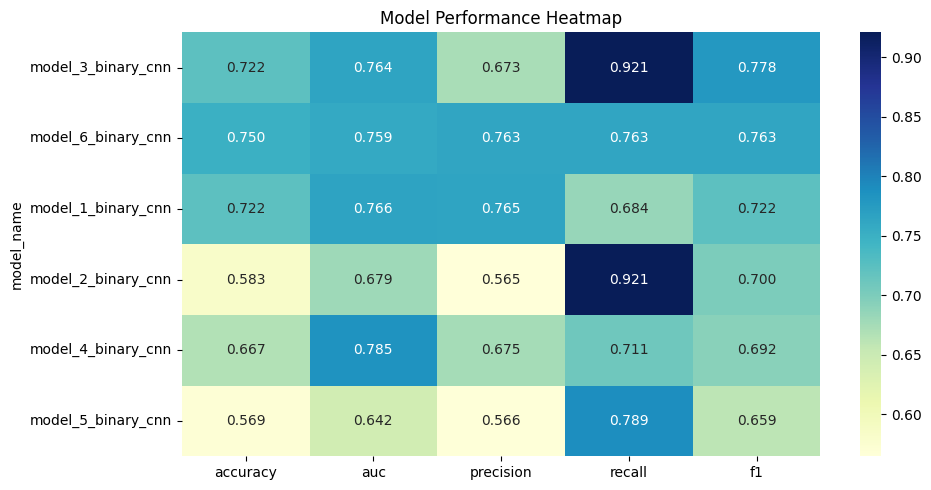

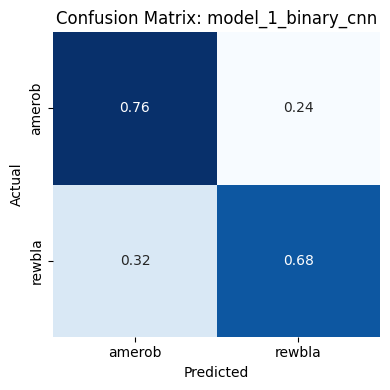

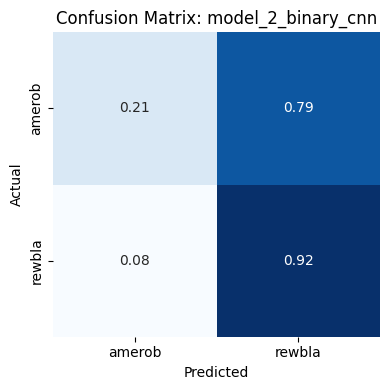

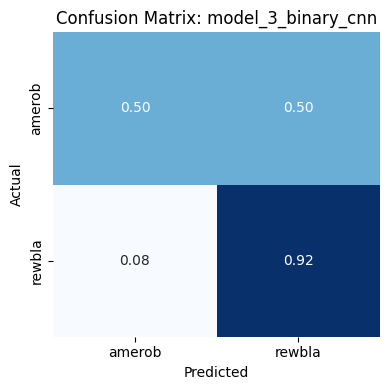

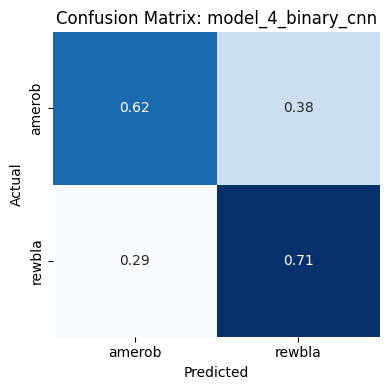

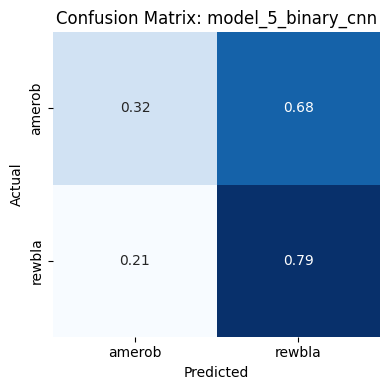

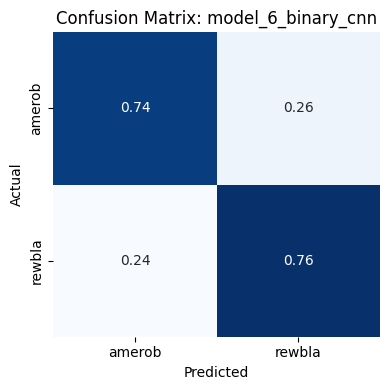

In [12]:
compare_models(model_1, model_2, model_3, model_4,model_5,model_6, normalize_cm=True)


In [13]:
import tensorflow as tf
import numpy as np
import h5py
import librosa.display
import matplotlib.pyplot as plt

def predict_and_visualize_binary_species(model_path):
    """
    Loads a trained binary classification model and predicts species ('amerob' vs 'rewbla')
    from pre-normalized spectrograms stored in an HDF5 file.
    Visualizes the original (unpadded) spectrogram and prints predictions.
    """
    hdf5_path = "D:/University_Course_work/StatsML-2/Deeplearning/Practical_Home_Work/species_learning_with_deep_learning/Data/test_bird_spectrograms.hdf5"
    species_labels = ['amerob', 'rewbla']
    target_shape = (128, 517)


    model = tf.keras.models.load_model(model_path)

    with h5py.File(hdf5_path, 'r') as h5f:
        spectrogram_datasets = list(h5f.keys())

        for dataset_name in spectrogram_datasets:
            raw_spectrogram = h5f[dataset_name][...]  

      
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(raw_spectrogram, x_axis='time', y_axis='mel', sr=22050, cmap='gray')
            plt.title(f"Original Spectrogram: {dataset_name}")
            plt.colorbar(format='%+2.0f')
            plt.tight_layout()
            plt.show()

  
            padded_spectrogram = raw_spectrogram
            if raw_spectrogram.shape[1] < target_shape[1]:
                pad_width = target_shape[1] - raw_spectrogram.shape[1]
                padded_spectrogram = np.pad(raw_spectrogram, ((0, 0), (0, pad_width)), mode='constant')
            else:
                padded_spectrogram = raw_spectrogram[:, :target_shape[1]]

   
            input_tensor = np.expand_dims(padded_spectrogram, axis=(0, -1))  


            predicted_prob = model.predict(input_tensor)[0][0]
            predicted_label = 1 if predicted_prob >= 0.5 else 0

  
            print(f"Predicted label for {dataset_name}: {species_labels[predicted_label]}")
            print("Prediction confidence:")
            print(f"  amerob: {1 - predicted_prob:.4f}")
            print(f"  rewbla: {predicted_prob:.4f}")
            print("-" * 50)


Prediction on model 5 which has very low accuracy

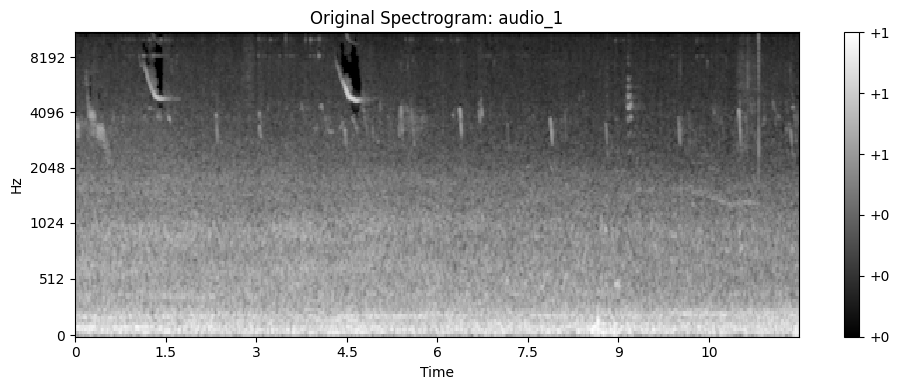

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Predicted label for audio_1: rewbla
Prediction confidence:
  amerob: 0.4598
  rewbla: 0.5402
--------------------------------------------------


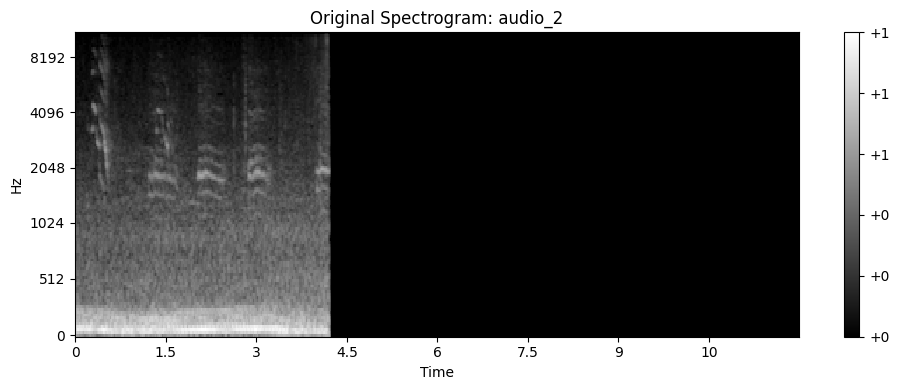

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted label for audio_2: rewbla
Prediction confidence:
  amerob: 0.4957
  rewbla: 0.5043
--------------------------------------------------


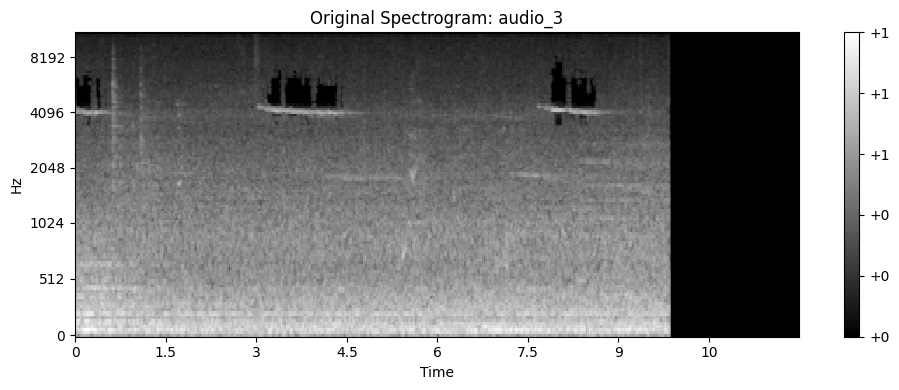

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted label for audio_3: rewbla
Prediction confidence:
  amerob: 0.4702
  rewbla: 0.5298
--------------------------------------------------


In [17]:
predict_and_visualize_binary_species("D:/University_Course_work/StatsML-2/Deeplearning/Practical_Home_Work/species_learning_with_deep_learning/training_and_evaluation/binarymodels/model_5_binary_cnn.keras")


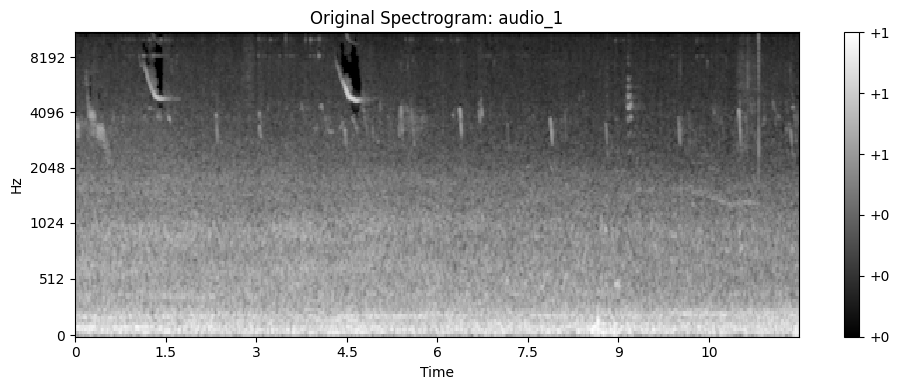

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted label for audio_1: rewbla
Prediction confidence:
  amerob: 0.2417
  rewbla: 0.7583
--------------------------------------------------


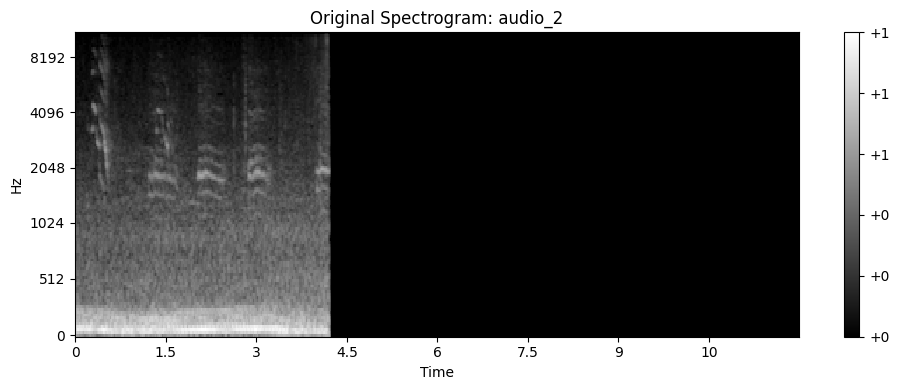

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted label for audio_2: rewbla
Prediction confidence:
  amerob: 0.4151
  rewbla: 0.5849
--------------------------------------------------


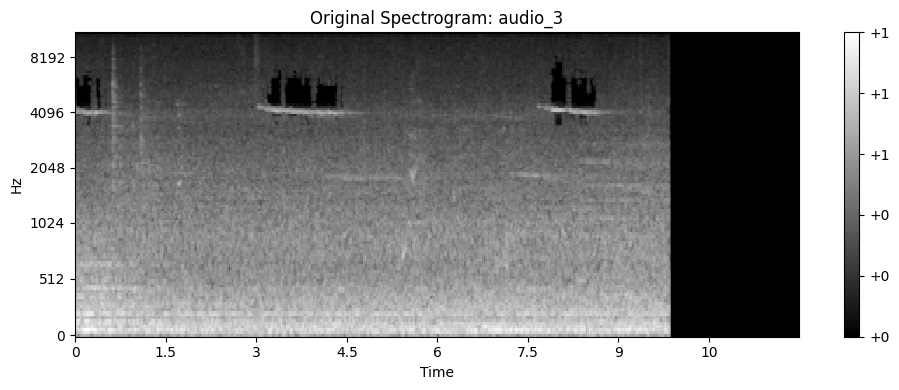

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted label for audio_3: rewbla
Prediction confidence:
  amerob: 0.2913
  rewbla: 0.7087
--------------------------------------------------


In [18]:
predict_and_visualize_binary_species("D:/University_Course_work/StatsML-2/Deeplearning/Practical_Home_Work/species_learning_with_deep_learning/training_and_evaluation/binarymodels/model_3_binary_cnn.keras")


The good model based on the F1 score is model 3 but the recall score is 0.92 which tells the model is biased towards rewbella so the good model is model 6 

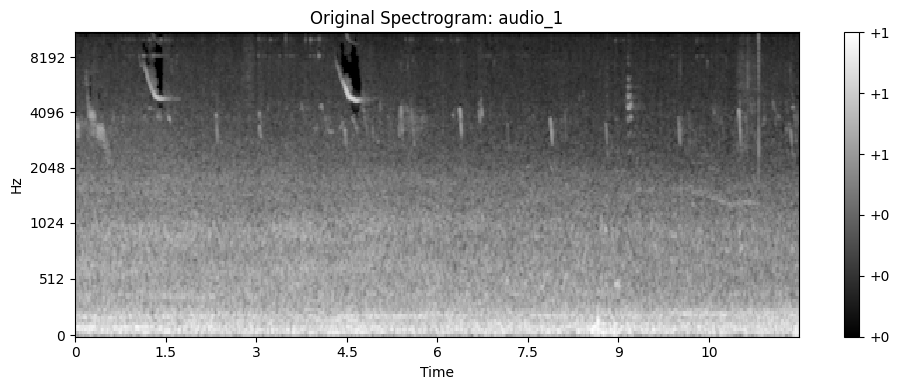

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted label for audio_1: rewbla
Prediction confidence:
  amerob: 0.4320
  rewbla: 0.5680
--------------------------------------------------


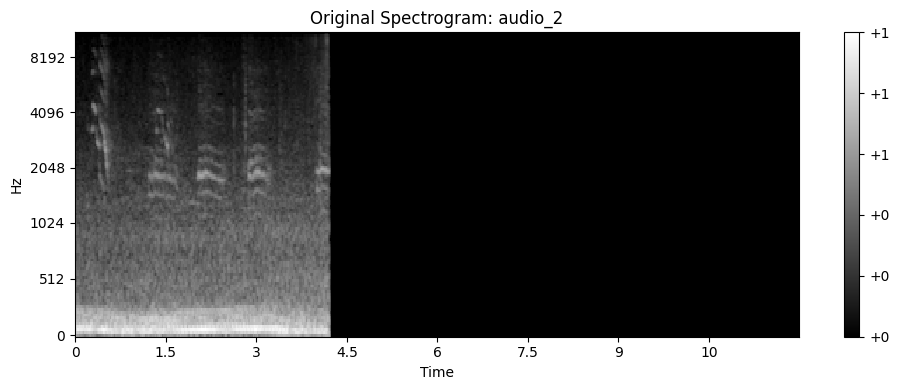

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted label for audio_2: amerob
Prediction confidence:
  amerob: 0.5191
  rewbla: 0.4809
--------------------------------------------------


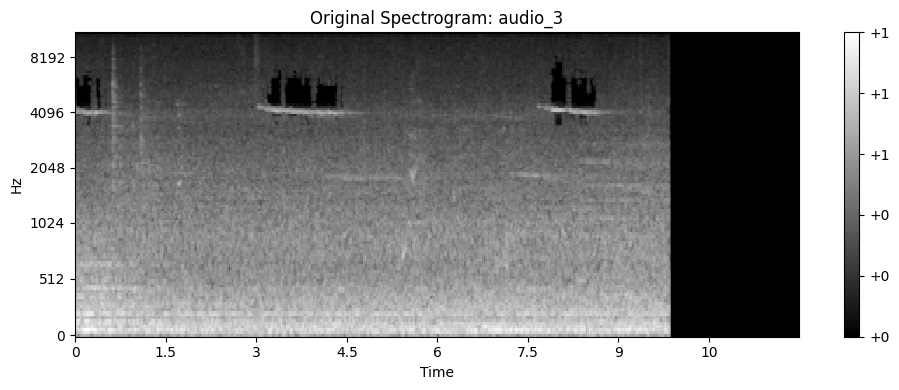

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted label for audio_3: rewbla
Prediction confidence:
  amerob: 0.4607
  rewbla: 0.5393
--------------------------------------------------


In [19]:
predict_and_visualize_binary_species("D:/University_Course_work/StatsML-2/Deeplearning/Practical_Home_Work/species_learning_with_deep_learning/training_and_evaluation/binarymodels/model_6_binary_cnn.keras")
